# Plot benchmarking results

Import modules:

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd
import numpy as np

import os
import re
import itertools

Data paths, where benchmarking logs are located:

In [2]:
data_path = './'
log_dir_prefixes = {'pyre': 'benchmarks_pyre',
                    'smpl': 'benchmarks_smpl'}

Definitions for loading results logs:

In [3]:
def read_pyre_experiment_dir(experiment_dir_path):
    df = pd.DataFrame()
    path, _, log_files = next(os.walk(experiment_dir_path))

    for log_file in log_files:
        if log_file.startswith('.'):
            # Skip hidden files
            continue

        with open(path + '/' + log_file) as file:
            # Get the number of properties and the line nr. of the first property
            properties_count = 0
            properties_first_line_nr = 0
            regex = re.compile('(?P<count>[0-9]+) properties for each run')
            for line in itertools.islice(file, 0, 50):
                properties_first_line_nr += 1

                match = regex.match(line)
                if match is not None:
                    properties_count = int(match.group('count'))
                    break
            file.seek(0)

            # Get the properties names
            properties_names = []
            for line in itertools.islice(file, properties_first_line_nr, properties_first_line_nr + properties_count):
                properties_names.append(line.strip().split()[0])
            file.seek(0)

            # Get the number of runs and the line nr. of the first run
            runs_count = 0
            runs_first_line_nr = 0
            regex = re.compile('(?P<count>[0-9]+) runs')
            for line in itertools.islice(file, 0, 50):
                runs_first_line_nr += 1

                match = regex.match(line)
                if match is not None:
                    runs_count = int(match.group('count'))
                    break

        new_df = pd.read_table(path + '/' + log_file,
                               delimiter='; ',
                               engine='python',
                               header=runs_first_line_nr - 1,
                               names=properties_names,
                               nrows=runs_count)
        df = pd.concat([df, new_df])

    return df


def read_logs(data_path, framework):
    df = pd.DataFrame()

    _, dirs, _ = next(os.walk(data_path))
    for dir in dirs:
        split_name = re.split(log_dir_prefixes[framework], dir)
        if len(split_name) > 1:
            variant = split_name[-1][1:]
        else:
            continue

        _, experiment_dirs, log_files = next(os.walk(data_path + '/' + dir))
        if framework == 'pyre':
            for experiment_dir in experiment_dirs:
                new_df = read_pyre_experiment_dir(data_path + '/' + dir + '/' + experiment_dir)
                new_df['variant'] = variant
                new_df = new_df.rename(columns={'robowflex_planner_name': 'planner'})
                new_df['experiment'] = experiment_dir
                new_df = new_df.rename(columns={'query_index': 'problem index'})
                new_df['problem index'] += 1
                new_df['reverse'] = False
                new_df['success'] = (new_df['time'] < 60 * new_df['correct'])
                df = pd.concat([df, new_df], ignore_index=True)
        elif framework == 'smpl':
            for log_file in log_files:
                if log_file.startswith('.'):
                    # Skip hidden files
                    continue

                new_df = pd.read_table(data_path + '/' + dir + '/' + log_file, delimiter=', ', engine='python')
                new_df['variant'] = variant
                new_df = new_df.rename(columns={'problem name': 'experiment'})
                new_df['reverse'] = False if 'reverse' not in new_df.columns else new_df['reverse'].astype(bool)
                new_df['success'] = new_df['time'] < 60 * (new_df['expansions'] > 0)
                df = pd.concat([df, new_df], ignore_index=True)

            # Filter out fails for forward/reverse paths, and keep the successes
            for planner in df['planner'].unique():
                for experiment in df['experiment'].unique():
                    for index in df['problem index'].unique():
                        filter = (df['variant'] == variant) \
                                 & (df['planner'] == planner) \
                                 & (df['experiment'] == experiment) \
                                 & (df['problem index'] == index)

                        if df.loc[filter & (df['reverse'] == True)].empty:
                            continue

                        if (df.loc[filter & (df['reverse'] == False)]['success'].values
                            or df.loc[filter & (df['reverse'] == False)]['expansions'].values == 0):
                            df = df.drop(df.loc[filter & (df['reverse'] == True)].index)
                        else:
                            df = df.drop(df.loc[filter & (df['reverse'] == False)].index)

    return df[['variant', 'planner', 'experiment', 'problem index', 'reverse', 'time', 'success']]

Definitions for plotting the results:

In [4]:
EXPERIMENTS = ['shelf_zero_test', 'shelf_height_test', 'shelf_height_rot_test']
PALETTE = []

In [5]:
def plot_planning_times(dataframe, filter_failures=True,
                        hue='planner', hue_order=None,
                        file_name=None):
    if filter_failures:
        dataframe = dataframe[dataframe['success'] == True]

    if hue_order is None:
        hue_order = dataframe[hue].unique()

    g = sns.violinplot(data=dataframe,
                       # ax=ax,
                       x='experiment',
                       y='time',
                       cut=0,
                       hue=hue,
                       hue_order=hue_order,
                       palette=PALETTE[:len(dataframe[hue].unique())],
                       log_scale=10,
                       order=EXPERIMENTS)
    g.set(xlabel='Scenario', ylabel='Planning time (s)')
    # sns.despine()
    g.legend_.set_title(None)
    sns.move_legend(g, "upper center", bbox_to_anchor=(0.7, 1.17), title='')
    if file_name is not None:
        plt.savefig(file_name, format='svg')
    plt.show()


def plot_success_rate(dataframe, hue='planner', hue_order=None, file_name=None):
    if hue_order is None:
        hue_order = dataframe[hue].unique()

    g = sns.barplot(data=dataframe,
                    x='experiment',
                    y='success',
                    errorbar=None,
                    hue=hue,
                    hue_order=hue_order,
                    palette=PALETTE[:len(dataframe[hue].unique())],
                    order=EXPERIMENTS)
    g.set(xlabel='Scenario', ylabel='Success rate')
    sns.move_legend(g, "upper center", bbox_to_anchor=(0.7, 1.13), title='')
    # sns.despine()
    # plt.xticks(rotation=45)
    for i in g.containers:
        g.bar_label(i,)
    if file_name is not None:
        plt.savefig(file_name, format='svg')

## Load and inspect data from logs

In [6]:
pyre_df = read_logs(data_path, 'pyre')
smpl_df = read_logs(data_path, 'smpl')

# preview
df = pd.concat([pyre_df, smpl_df], ignore_index=True)
df

,variant,planner,experiment,problem index,reverse,time,success
0,ORIGINAL,UNIFORM_RRTConnectDefault,shelf_height_rot_test,1,False,20.797600,True
1,ORIGINAL,UNIFORM_RRTConnectDefault,shelf_height_rot_test,2,False,8.326390,True
2,ORIGINAL,UNIFORM_RRTConnectDefault,shelf_height_rot_test,3,False,6.904600,True
3,ORIGINAL,UNIFORM_RRTConnectDefault,shelf_height_rot_test,4,False,2.552410,True
4,ORIGINAL,UNIFORM_RRTConnectDefault,shelf_height_rot_test,5,False,60.019100,False
...,...,...,...,...,...,...,...
3307,PREVIOUS,arastar,shelf_height_test,96,False,0.864372,True
3308,PREVIOUS,arastar,shelf_height_test,97,False,0.108572,True
3309,PREVIOUS,arastar,shelf_height_test,98,False,0.068160,True
3310,PREVIOUS,arastar,shelf_height_test,99,False,60.000100,False


Failed cases in SMPL's ARA*:
  - 0.0s means collision in start/end state
  - 60.0s means valid start/end states but failure to find a path

In [7]:
# failed in SMPL
filter = ((df['variant'] == '') & (df['planner'] == 'arastar')
          & (df['success'] == False)
          # & (df['time'] == 0)
          # & (df['reverse'] == False)
          )

# # failed in RRTConnect
# filter = ((df['variant'] == '') & (df['planner'] == 'UNIFORM_RRTConnectDefault')
#           & (df['success'] == False))

df.loc[filter].sort_values(by=['experiment', 'time'])

,variant,planner,experiment,problem index,reverse,time,success
2703,,arastar,shelf_height_rot_test,8,True,0.0000,False
2711,,arastar,shelf_height_rot_test,20,True,0.0000,False
2718,,arastar,shelf_height_rot_test,36,True,0.0000,False
2728,,arastar,shelf_height_rot_test,56,True,0.0000,False
2751,,arastar,shelf_height_rot_test,90,True,0.0000,False
2752,,arastar,shelf_height_rot_test,93,True,0.0000,False
2932,,arastar,shelf_height_rot_test,47,False,0.0000,False
2938,,arastar,shelf_height_rot_test,67,False,0.0000,False
2719,,arastar,shelf_height_rot_test,38,True,60.0000,False
2754,,arastar,shelf_height_rot_test,99,True,60.0000,False


RRT-Connect's performance in those cases where ARA* had collisions in start/end states:

In [8]:
filter = ((df['variant'] == '') & (df['planner'] == 'UNIFORM_RRTConnectDefault')
          &
          (((df['experiment'] == 'shelf_height_rot_test')
             &
             df['problem index'].isin([8, 20, 36, 47, 67, 56, 90, 93]))
            |
            ((df['experiment'] == 'shelf_height_test')
             &
             df['problem index'].isin([12]))))

df.loc[filter].sort_values(by=['experiment', 'problem index'])

,variant,planner,experiment,problem index,reverse,time,success
1807,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,8,False,3.319300,True
1819,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,20,False,60.003600,False
1835,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,36,False,1.223190,True
1846,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,47,False,16.958400,True
1855,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,56,False,40.103000,True
1866,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,67,False,34.681000,True
1889,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,90,False,0.122737,False
1892,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,93,False,8.528510,True
2411,,UNIFORM_RRTConnectDefault,shelf_height_test,12,False,60.002000,False


RRT-Connect's performance in those cases where ARA* failed to find a solution:

In [9]:
filter = ((df['variant'] == '') & (df['planner'] == 'UNIFORM_RRTConnectDefault')
          &
          (((df['experiment'] == 'shelf_height_rot_test')
             &
             df['problem index'].isin([33, 38, 40, 43, 72, 99]))))

df.loc[filter].sort_values(by=['experiment', 'problem index'])

,variant,planner,experiment,problem index,reverse,time,success
1832,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,33,False,60.00150,False
1837,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,38,False,17.11740,True
1839,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,40,False,6.12102,True
1842,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,43,False,9.88563,True
1871,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,72,False,4.81237,True
1898,,UNIFORM_RRTConnectDefault,shelf_height_rot_test,99,False,60.00300,False


## Visualize the data

Performance impact on OMPL's RRT-Connect due to the _modified_ spheres collision model, compared to the _original_:

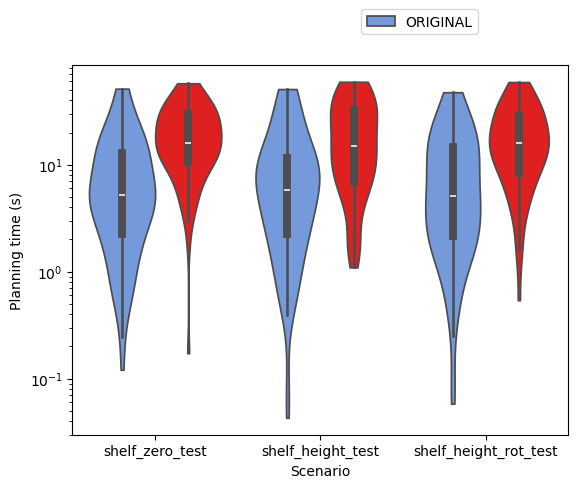

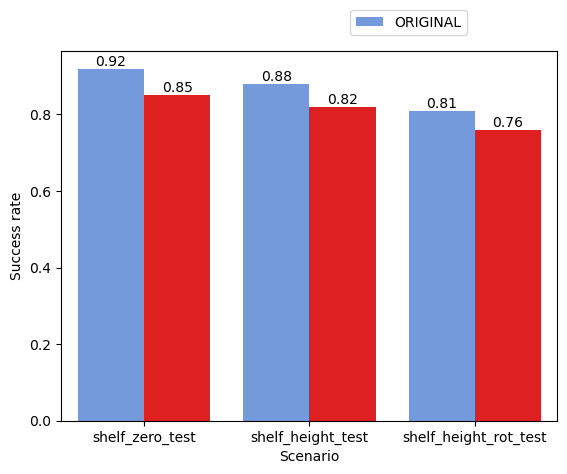

In [10]:
variants = ['ORIGINAL', '',]
planners = ['UNIFORM_RRTConnectDefault']
filter = df['variant'].isin(variants) & df['planner'].isin(planners)

PALETTE = ['cornflowerblue', 'red', 'yellowgreen']

plot_planning_times(df.loc[filter], filter_failures=True, hue='variant', hue_order=variants, file_name='rrtconnect_planning_time.svg')
plot_success_rate(df.loc[filter], hue='variant', hue_order=variants, file_name='rrtconnect_success_rate.svg')

Definitions for plotting success rate in a stacked bar plot:

In [11]:
# get counts of experiment results
def get_counts(data):
    df = pd.DataFrame()

    for experiment in data['experiment'].unique():
        for planner in data['planner'].unique():
            base_filter = (data['experiment'] == experiment) & (data['planner'] == planner)

            filters = {'success forward':  (base_filter
                                            & (data['success'] == True)
                                            & (data['reverse'] == False)),
                       'success backward': (base_filter
                                            & (data['success'] == True)
                                            & (data['reverse'] == True)),
                       'failure':          (base_filter
                                            & (data['success'] == False)
                                            & (data['time'] > 0)),
                       'unsolvable':       (base_filter
                                            & (data['success'] == False)
                                            & (data['time'] == 0))}

            for status, filter in filters.items():
                new_df = pd.DataFrame({'experiment': experiment,
                                       'planner': planner,
                                       'status': status,
                                       'count': [data.loc[filter].count()['planner']]})

                df = pd.concat([df, new_df], ignore_index=True)

    return df

def stack_catplot(x, y, cat, stack, data, file_name=None,
                  palette=2*['darkgreen', 'seagreen', 'orangered', 'darkslateblue']):
    plt.figure(figsize=(6, 4))
    ax = plt.gca()
    # pivot the data based on categories and stacks
    df = data.pivot_table(values=y, index=[cat, x], columns=stack, 
                          dropna=False, aggfunc='sum').fillna(0)
    ncat = data[cat].nunique()
    nx = data[x].nunique()
    nstack = data[stack].nunique()
    range_x = np.arange(nx)
    width = 0.8 / ncat # width of each bar
    
    for i, c in enumerate(data[cat].unique()):
        # iterate over categories, i.e., Conditions
        # calculate the location of each bar
        loc_x = (0.5 + i - ncat / 2) * width + range_x
        bottom = 0
        for j, s in enumerate(data[stack].unique()):
            # iterate over stacks, i.e., Hosts
            # obtain the height of each stack of a bar
            height = df.loc[c][s].values
            # plot the bar, you can customize the color yourself
            ax.bar(x=-loc_x, height=height, bottom=bottom, width=width, 
                   color=palette[j + i * nstack], zorder=10, edgecolor='black', linewidth=0.5)
            # change the bottom attribute to achieve a stacked barplot
            bottom += height
    # make xlabel
    ax.set_xticks(-range_x)
    ax.set_xticklabels(data[x].unique())
    ax.set_xlabel('Scenario')
    ax.set_ylabel('Count')
    # make legend
    plt.legend([Patch(facecolor=palette[i]) for i in range(nstack)], 
               [f"{s}" for c in data[cat].unique() for s in data[stack].unique()],
               bbox_to_anchor=(0.82, 1.32), loc='upper center', borderaxespad=0.)
    # plt.grid()
    ax.text(x=-1.80, y=104, s='RRT-Connect', ha='center', rotation=90)
    ax.text(x=-2.20, y=104, s='ARA*', ha='center', rotation=90)
    if file_name is not None:
        plt.savefig(file_name, format='svg', bbox_inches='tight')

### Benchmarking results

Plots:

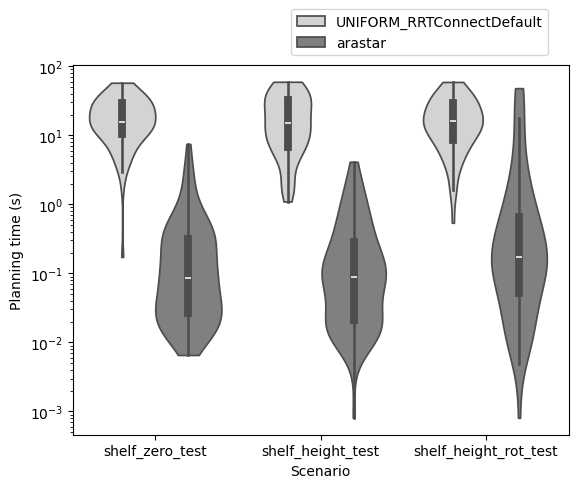

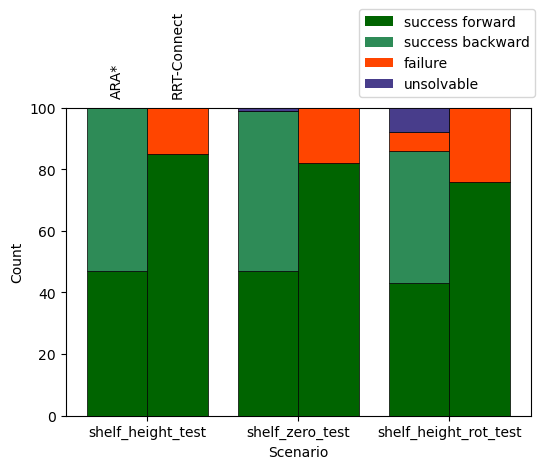

In [12]:
variants = ['']
planners = ['UNIFORM_RRTConnectDefault', 'arastar']
filter = df['variant'].isin(variants) & df['planner'].isin(planners)

PALETTE = ['lightgrey', 'grey']

plot_planning_times(df.loc[filter], hue_order=planners, file_name='planning_time.svg')
# plot_success_rate(df.loc[filter], hue_order=planners, file_name='success_rate.svg')
stack_catplot(x='experiment', y='count', cat='planner', stack='status', data=get_counts(df.loc[filter]),
              file_name='success_rate.svg')

Success/failure counts:

In [13]:
print(get_counts(df.loc[filter]))

               experiment                    planner            status  count
0   shelf_height_rot_test  UNIFORM_RRTConnectDefault   success forward     76
1   shelf_height_rot_test  UNIFORM_RRTConnectDefault  success backward      0
2   shelf_height_rot_test  UNIFORM_RRTConnectDefault           failure     24
3   shelf_height_rot_test  UNIFORM_RRTConnectDefault        unsolvable      0
4   shelf_height_rot_test                    arastar   success forward     43
5   shelf_height_rot_test                    arastar  success backward     43
6   shelf_height_rot_test                    arastar           failure      6
7   shelf_height_rot_test                    arastar        unsolvable      8
8         shelf_zero_test  UNIFORM_RRTConnectDefault   success forward     85
9         shelf_zero_test  UNIFORM_RRTConnectDefault  success backward      0
10        shelf_zero_test  UNIFORM_RRTConnectDefault           failure     15
11        shelf_zero_test  UNIFORM_RRTConnectDefault        unso